In [1]:
#DIRECTORY = "/home/saint/datasets/competitions/tgs-salt-identification-challenge"
DIRECTORY = "/Users/alex/code/dl/brainopia/berloga-dl/datasets/salt" # local
SAVE_PATH = "/Users/alex/code/dl/brainopia/berloga-dl/models/salt"

In [ ]:
from src.utils.checkpoints import save_checkpoint, load_checkpoint

In [36]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

import torchvision
from torchvision import models

import os, cv2, glob
import numpy as np
import pandas as pd
from pathlib import Path
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import jaccard_similarity_score

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline
import seaborn as sns
sns.set_style("white")

In [18]:
# https://github.com/leigh-plt/cs231n_hw2018/blob/master/assignment2/pytorch_tutorial.ipynb
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

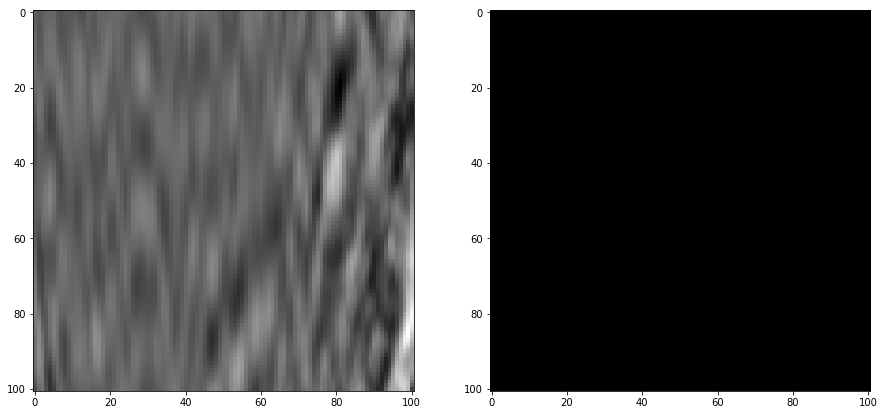

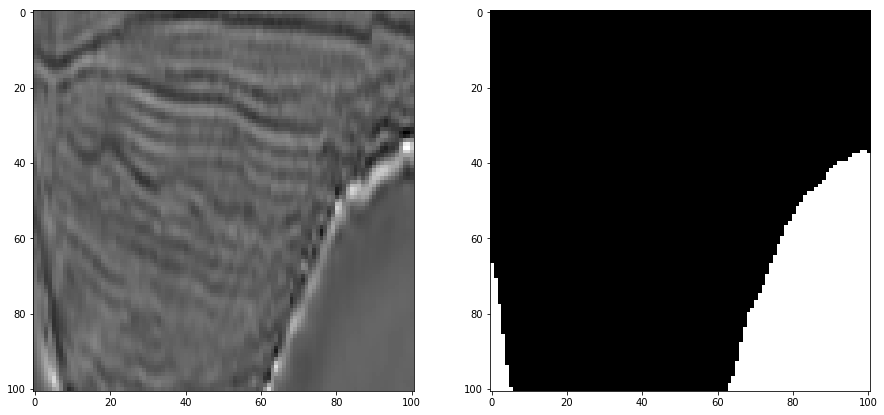

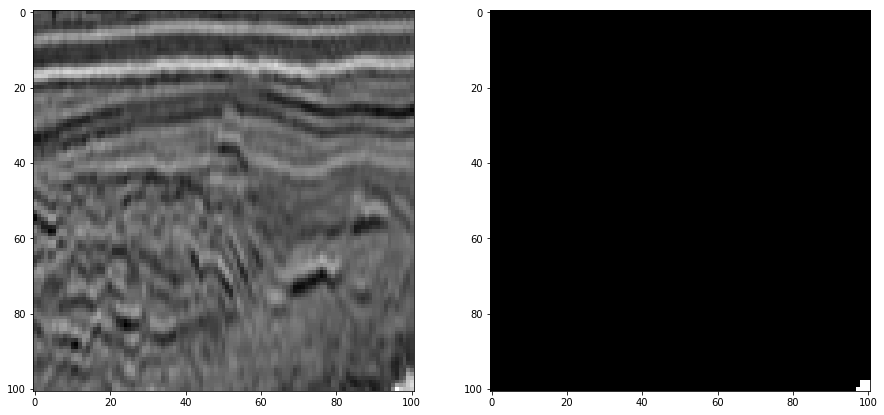

In [75]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf'] #,'7dfdf6eeb8','7e5a6e5013']
def show(ids):
    for j, img_name in enumerate(ids):
        q = j + 1
        img = cv2.imread(DIRECTORY + '/train/images/' + img_name + '.png')
        img_mask = cv2.imread(DIRECTORY + '/train/masks/' + img_name + '.png')

        plt.figure(figsize=(15,10))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.subplot(1, 2, 2)
        plt.imshow(img_mask)
    plt.show()
show(ids)

In [13]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
F.alpha_dropout()

In [22]:
class UNet11(nn.Module):
    def __init__(self, num_filters=32):
        """
        :param num_classes:
        :param num_filters:
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutions are from VGG11
        self.encoder = models.vgg11().features
        
        # "relu" layer is taken from VGG probably for generality, but it's not clear 
        self.relu = self.encoder[1]
        
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)
        
        self.final = nn.Conv2d(num_filters, 1, kernel_size=1, )

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv1 = F.dropout()
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        # Deconvolutions with copies of VGG11 layers of corresponding size 
        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return torch.sigmoid(self.final(dec1))


def unet11(**kwargs):
    model = UNet11(**kwargs)

    return model

def get_model():
    model = unet11()
    model.train()
    return model.cuda()

In [15]:
def load_image(path, mask = False):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, _ = img.shape

    # Padding in needed for UNet models because they need image size to be divisible by 32 
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)
    if mask:
        # Convert mask to 0 and 1 format
        img = img[:, :, 0:1] // 255
        return torch.from_numpy(np.transpose(img, (2, 0, 1)).astype('float32'))
    else:
        img = img / 255.0
        return torch.from_numpy(np.transpose(img, (2, 0, 1)).astype('float32'))

In [16]:
# Adapted from vizualization kernel
class TGSSaltDataset(data.Dataset):
    def __init__(self, root_path, file_list, is_test = False):
        self.is_test = is_test
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = load_image(image_path)
        
        if self.is_test:
            return (image,)
        else:
            mask = load_image(mask_path, mask = True)
            return image, mask

depths_df = pd.read_csv(os.path.join(DIRECTORY, 'train.csv'))

train_path = os.path.join(DIRECTORY, 'train')
file_list = list(depths_df['id'].values)

In [76]:
file_list_val = file_list[::10]
file_list_train = [f for f in file_list if f not in file_list_val]
dataset = TGSSaltDataset(train_path, file_list_train)
dataset_val = TGSSaltDataset(train_path, file_list_val)

model = get_model()
#
epoch = 18
learning_rate = 1e-4
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for e in range(epoch):
    train_loss = []
    for image, mask in tqdm_notebook(data.DataLoader(dataset, batch_size = 30, shuffle = True)):
        image = image.type(torch.FloatTensor).cuda()
        y_pred = model(Variable(image))
        loss = loss_fn(y_pred, Variable(mask.cuda()))

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss.append(loss.data[0])
        
    val_loss = []
    for image, mask in data.DataLoader(dataset_val, batch_size = 50, shuffle = False):
        image = image.cuda()
        y_pred = model(Variable(image))

        loss = loss_fn(y_pred, Variable(mask.cuda()))
        val_loss.append(loss.data[0])

    print("Epoch: %d, Train: %.3f, Val: %.3f" % (e, np.mean(train_loss), np.mean(val_loss)))
# save the final model
save_checkpoint('/home/saint/models/salt/tgs-%i.pth' % epoch, model, optimizer)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0, Train: 0.583, Val: 0.507
Epoch: 1, Train: 0.470, Val: 0.416
Epoch: 2, Train: 0.399, Val: 0.391
Epoch: 3, Train: 0.337, Val: 0.290
Epoch: 4, Train: 0.298, Val: 0.261
Epoch: 5, Train: 0.290, Val: 0.251
Epoch: 6, Train: 0.253, Val: 0.256
Epoch: 7, Train: 0.238, Val: 0.220
Epoch: 8, Train: 0.218, Val: 0.211
Epoch: 9, Train: 0.210, Val: 0.200
Epoch: 10, Train: 0.194, Val: 0.197
Epoch: 11, Train: 0.188, Val: 0.187
Epoch: 12, Train: 0.179, Val: 0.188
Epoch: 13, Train: 0.171, Val: 0.166
Epoch: 14, Train: 0.160, Val: 0.172
Epoch: 15, Train: 0.145, Val: 0.172
Epoch: 16, Train: 0.145, Val: 0.183
Epoch: 17, Train: 0.149, Val: 0.196
model saved to /home/saint/models/salt/tgs-18.pth


In [77]:
test_path = os.path.join(DIRECTORY, 'test')
test_file_list = glob.glob(os.path.join(test_path, 'images', '*.png'))
test_file_list = [f.split('/')[-1].split('.')[0] for f in test_file_list]
print('First 3 names of test files:', test_file_list[:3])

First 3 names of test files: ['5ea1fe5010', '2df17e4028', 'd5f32fb9d8']


In [78]:
print("Test size: " + str(len(test_file_list)))
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True)

all_predictions = []
for image in tqdm_notebook(data.DataLoader(test_dataset, batch_size = 30)):
    image = image[0].type(torch.FloatTensor).cuda()
    y_pred = model(Variable(image)).cpu().data.numpy()
    all_predictions.append(y_pred)
all_predictions_stacked = np.vstack(all_predictions)[:, 0, :, :]

Test size: 18000


In [79]:
height, width = 101, 101

if height % 32 == 0:
    y_min_pad = 0
    y_max_pad = 0
else:
    y_pad = 32 - height % 32
    y_min_pad = int(y_pad / 2)
    y_max_pad = y_pad - y_min_pad

if width % 32 == 0:
    x_min_pad = 0
    x_max_pad = 0
else:
    x_pad = 32 - width % 32
    x_min_pad = int(x_pad / 2)
    x_max_pad = x_pad - x_min_pad

In [80]:
all_predictions_stacked = all_predictions_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]

In [81]:
all_predictions_stacked.shape


(18000, 101, 101)

In [82]:
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True)

val_predictions = []
val_masks = []
for image, mask in tqdm_notebook(data.DataLoader(dataset_val, batch_size = 30)):
    image = Variable(image.type(torch.FloatTensor).cuda())
    y_pred = model(image).cpu().data.numpy()
    val_predictions.append(y_pred)
    val_masks.append(mask)
    
val_predictions_stacked = np.vstack(val_predictions)[:, 0, :, :]

val_masks_stacked = np.vstack(val_masks)[:, 0, :, :]
val_predictions_stacked = val_predictions_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]

val_masks_stacked = val_masks_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]
val_masks_stacked.shape, val_predictions_stacked.shape

((400, 101, 101), (400, 101, 101))

In [83]:
metric_by_threshold = []
for threshold in np.linspace(0, 1, 11):
    val_binary_prediction = (val_predictions_stacked > threshold).astype(int)
    
    iou_values = []
    for y_mask, p_mask in zip(val_masks_stacked, val_binary_prediction):
        iou = jaccard_similarity_score(y_mask.flatten(), p_mask.flatten())
        iou_values.append(iou)
    iou_values = np.array(iou_values)
    
    accuracies = [
        np.mean(iou_values > iou_threshold)
        for iou_threshold in np.linspace(0.5, 0.95, 10)
    ]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))
    metric_by_threshold.append((np.mean(accuracies), threshold))
    
best_metric, best_threshold = max(metric_by_threshold)

Threshold: 0.0, Metric: 0.138
Threshold: 0.1, Metric: 0.873
Threshold: 0.2, Metric: 0.895
Threshold: 0.3, Metric: 0.903
Threshold: 0.4, Metric: 0.912
Threshold: 0.5, Metric: 0.913
Threshold: 0.6, Metric: 0.914
Threshold: 0.7, Metric: 0.914
Threshold: 0.8, Metric: 0.918
Threshold: 0.9, Metric: 0.914
Threshold: 1.0, Metric: 0.640


In [84]:
threshold = best_threshold
binary_prediction = (all_predictions_stacked > threshold).astype(int)

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

all_masks = []
for p_mask in list(binary_prediction):
    p_mask = rle_encoding(p_mask)
    all_masks.append(' '.join(map(str, p_mask)))

In [85]:
submit = pd.DataFrame([test_file_list, all_masks]).T
submit.columns = ['id', 'rle_mask']
submit.to_csv('/home/saint/submissions/salt/submit_baseline_torch_18epochs.csv', index = False)